In [20]:
# 재시작 없이 import 파일 자동 적용
%load_ext autoreload
%autoreload 2

In [1]:
import pickle
import numpy as np
import pandas as pd
from scipy import interpolate
import neurokit2 as nk
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
import h5py

# Data Loading

In [3]:
with h5py.File("./dataset/features.h5", 'r') as f:
    ecg = f['ecg'][:]
    label = f['label'][:]

In [2]:
# resampling to 250Hz
def resampling(array, freq, kind='linear'):
    t = np.linspace(1, len(array), len(array))
    f = interpolate.interp1d(t, array, kind=kind)
    t_new = np.linspace(1, len(array), int(len(array)/freq * 250))
    new_array = f(t_new)
    return new_array


# standard normalization 
def normalize(data):
    scaler = StandardScaler()
    data_norm = scaler.fit_transform(data)
    return data_norm


# function of R peaks of a resampled trial
def R_Peaks(ecg_data):
    # get R Peak positions
    pos = []
    # get R Peak intervals
    trial_interval = []
    for ch in range(ecg_data.shape[1]):
        cleaned_ecg = nk.ecg_clean(ecg_data[:, ch], sampling_rate=250, method='neurokit')
        signals, info = nk.ecg_peaks(cleaned_ecg, sampling_rate=250, correct_artifacts=False)
        peaks = signals[signals['ECG_R_Peaks']==1].index.to_list()
        pos.append(peaks)
        channel_interval = []
        for i in range(len(peaks)-1):
            channel_interval.append(peaks[i+1] - peaks[i])
        trial_interval.append(channel_interval)
        
    df_peaks = pd.DataFrame(pos) # [C=15, num of the R-Peaks of a channel]
    df = pd.DataFrame(trial_interval).T
    med = df.median()
    return df, med, df_peaks

In [5]:
ecg.shape

(2400, 5000, 12)

In [6]:
ecg[0].shape

(5000, 12)

In [7]:
cnt = 0
p_ecg = []

for ecg_data in tqdm(ecg):
    sub = []
    trial = []
    for ch in range(ecg_data.shape[1]):
        # data = resampling(ecg_data[:,ch], freq=500, kind='linear')
        data = ecg_data[:, ch]
        trial.append(data)
        
    trial = np.array(trial).T
    # trial_norm = normalize(trial)
    sub.append(trial)

    sub = np.array(sub)
    sub = sub.reshape(-1, 5000, sub.shape[-1])  # split 10s trial into 1s sample

    p_ecg.append(sub)
    # np.save('./dataset/Feature/feature_{}.npy'.format(cnt), sub)

    cnt +=1

print(sub.shape)

100%|██████████| 2400/2400 [00:00<00:00, 4580.27it/s] 

(1, 5000, 12)


In [8]:
np.array(p_ecg).shape

(2400, 1, 5000, 12)

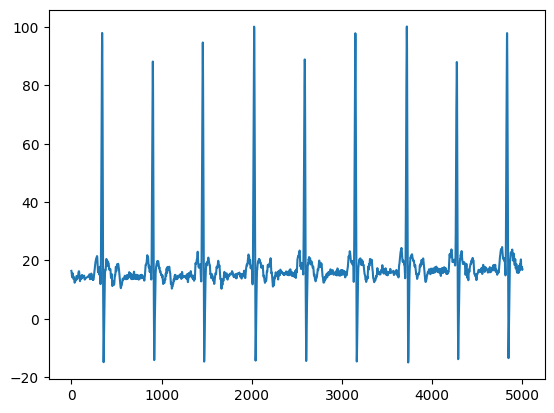

In [9]:
import matplotlib.pyplot as plt

plt.plot(sub[0,:,0])

plt.show()

In [10]:
df = pd.read_csv("./label/final_custom_label_20240912.csv")
df

,custom_new
0,1
1,0
2,1
3,1
4,1
...,...
2395,0
2396,1
2397,0
2398,0


In [11]:
custom_label = np.array(df['custom_new'].to_list())

In [14]:
with h5py.File("./dataset/processed_features.h5", 'w') as f:
    f.create_dataset('ecg', data=np.array(p_ecg))
    f.create_dataset('label', data=np.array(label))
    f.create_dataset('custom_label', data=custom_label)

# pkl to h5

In [3]:
with open("./dataset/Signal_Test_Public.pkl", 'rb') as f:
    signal = pickle.load(f)
  
# label  
# df = pd.read_csv("./label/public_test_label.csv")
df = pd.read_excel("./label/public_test_label.xlsx")
df_jamm = pd.read_excel("./label/public_test_label_jamm.xlsx")

In [4]:
df_jamm['check'] = df['check']

In [5]:
df

,index,label,check
0,0,0,NaN
1,1,0,NaN
2,2,0,NaN
3,3,0,NaN
4,4,0,NaN
...,...,...,...
295,295,1,NaN
296,296,0,NaN
297,297,0,NaN
298,298,1,cc


In [6]:
df_jamm

,index,jamm,label,difference,check
0,0.0,0,0,0,NaN
1,1.0,0,0,0,NaN
2,2.0,0,0,0,NaN
3,3.0,0,0,0,NaN
4,4.0,0,0,0,NaN
...,...,...,...,...,...
296,296.0,0,0,0,NaN
297,297.0,0,0,0,NaN
298,298.0,1,1,0,cc
299,299.0,1,1,0,NaN


In [7]:
test_signal = np.array(signal)

public_label = np.array(df['label'].to_list())
public_label_jamm = np.array(df_jamm['jamm'].to_list())

In [8]:
# 500 Hz

cnt = 0
p_ecg = []

for ecg_data in tqdm(test_signal):
    sub = []
    trial = []
    for ch in range(ecg_data.shape[1]):
        # data = resampling(ecg_data[:,ch], freq=500, kind='linear')
        data = ecg_data[:, ch]
        trial.append(data)
        
    trial = np.array(trial).T
    # trial_norm = normalize(trial)
    sub.append(trial)

    sub = np.array(sub)
    sub = sub.reshape(-1, 5000, sub.shape[-1]) 
    p_ecg.append(sub)
    # np.save('./dataset/KMedicon/Feature/feature_{}.npy'.format(cnt), sub)

    cnt +=1

print(sub.shape)

100%|██████████| 300/300 [00:00<00:00, 8638.49it/s]

(1, 5000, 12)


In [11]:
np.array(p_ecg).shape

(300, 1, 5000, 12)

In [9]:
# Public custom label
with h5py.File("./dataset/Signal_Test_Public_500hz.h5", 'w') as f:
    f.create_dataset('ecg', data=np.array(p_ecg))
    f.create_dataset('label', data=np.array(public_label))

In [10]:
# Public jamm label
with h5py.File("./dataset/Signal_Test_Public_500hz_jamm.h5", 'w') as f:
    f.create_dataset('ecg', data=np.array(p_ecg))
    f.create_dataset('label', data=np.array(public_label_jamm))

---
resampling 적용

In [16]:
# 500 -> 250 Hz Resampling

cnt = 0
p_ecg = []

for ecg_data in tqdm(test_signal):
    sub = []
    trial = []
    for ch in range(ecg_data.shape[1]):
        data = resampling(ecg_data[:,ch], freq=500, kind='linear')
        # data = ecg_data[:, ch]
        trial.append(data)
        
    trial = np.array(trial).T
    # trial_norm = normalize(trial)
    sub.append(trial)

    sub = np.array(sub)
    sub = sub.reshape(-1, 2500, sub.shape[-1])  # split 10s trial into 1s sample

    p_ecg.append(sub)
    # np.save('./dataset/KMedicon/Feature/feature_{}.npy'.format(cnt), sub)

    cnt +=1

print(sub.shape)

100%|██████████| 300/300 [00:00<00:00, 577.38it/s]

(1, 2500, 12)


In [17]:
np.array(p_ecg).shape

(300, 1, 2500, 12)

In [10]:
# Public custom label

# with h5py.File("./dataset/Signal_Test_Public_500hz.h5", 'w') as f:
with h5py.File("./dataset/Signal_Test_Public_250hz.h5", 'w') as f:
    f.create_dataset('ecg', data=np.array(p_ecg))
    f.create_dataset('label', data=np.array(public_label))

In [19]:
# Public jamm label

# with h5py.File("./dataset/Signal_Test_Public_500hz_jamm.h5", 'w') as f:
with h5py.File("./dataset/Signal_Test_Public_250hz_jamm.h5", 'w') as f:
    f.create_dataset('ecg', data=np.array(p_ecg))
    f.create_dataset('label', data=np.array(public_label_jamm))